In [141]:
# Importing Libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from time import time
from collections import Counter
from sklearn.tree import plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, classification_report
from sklearn.metrics import confusion_matrix,accuracy_score, roc_auc_score, roc_curve, precision_recall_curve
from sklearn.model_selection import GridSearchCV, KFold, StratifiedKFold, cross_val_score, train_test_split, RandomizedSearchCV

from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE,  ADASYN
from imblearn.combine import SMOTETomek, SMOTEENN
from imblearn.under_sampling import RandomUnderSampler

import warnings
warnings.filterwarnings('ignore')

In [142]:
# Importing Dataset
data = pd.read_csv('/content/Fraud_check.csv')
data.head()

,Undergrad,Marital.Status,Taxable.Income,City.Population,Work.Experience,Urban
0,NO,Single,68833,50047,10,YES
1,YES,Divorced,33700,134075,18,YES
2,NO,Married,36925,160205,30,YES
3,YES,Single,50190,193264,15,YES
4,NO,Married,81002,27533,28,NO


# EDA


In [143]:
data.shape

(600, 6)

In [144]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Undergrad        600 non-null    object
 1   Marital.Status   600 non-null    object
 2   Taxable.Income   600 non-null    int64 
 3   City.Population  600 non-null    int64 
 4   Work.Experience  600 non-null    int64 
 5   Urban            600 non-null    object
dtypes: int64(3), object(3)
memory usage: 28.2+ KB


In [145]:
data.describe()

,Taxable.Income,City.Population,Work.Experience
count,600.000000,600.000000,600.000000
mean,55208.375000,108747.368333,15.558333
std,26204.827597,49850.075134,8.842147
min,10003.000000,25779.000000,0.000000
25%,32871.500000,66966.750000,8.000000
50%,55074.500000,106493.500000,15.000000
75%,78611.750000,150114.250000,24.000000
max,99619.000000,199778.000000,30.000000


# Checking null value

In [146]:
data.isnull().sum()

Undergrad          0
Marital.Status     0
Taxable.Income     0
City.Population    0
Work.Experience    0
Urban              0
dtype: int64

# Checking duplicated value

In [147]:
data.duplicated().sum()

0

# Feature Engineering

### Lets assume: taxable_income <= 30000 as “Risky=0” and others are “Good=1”

In [148]:
data['Taxable.Income'].describe()

count      600.000000
mean     55208.375000
std      26204.827597
min      10003.000000
25%      32871.500000
50%      55074.500000
75%      78611.750000
max      99619.000000
Name: Taxable.Income, dtype: float64

In [149]:
# Converting taxable_income <= 30000 as "Risky" and others are "Good"
data_new=data.copy()
data_new['taxable_category'] = pd.cut(x = data['Taxable.Income'], bins = [10002,30000,99620], labels = ['Risky', 'Good'])
data_new.head()

,Undergrad,Marital.Status,Taxable.Income,City.Population,Work.Experience,Urban,taxable_category
0,NO,Single,68833,50047,10,YES,Good
1,YES,Divorced,33700,134075,18,YES,Good
2,NO,Married,36925,160205,30,YES,Good
3,YES,Single,50190,193264,15,YES,Good
4,NO,Married,81002,27533,28,NO,Good


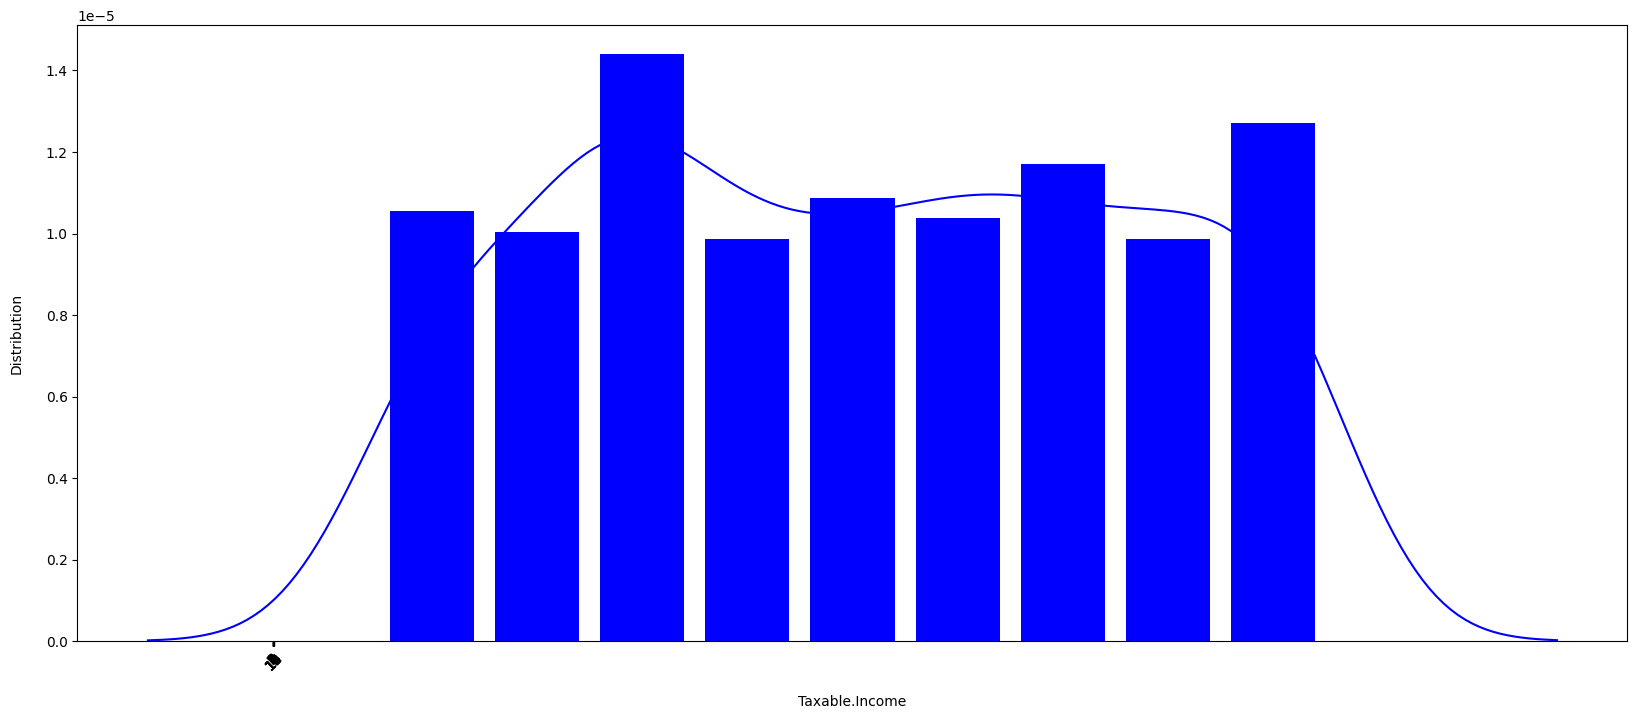

In [150]:
def distplot(param):
    plt.figure(figsize=(20,8))
    sns.distplot(data[param], color = "blue", hist_kws={"rwidth":0.80, 'alpha':1.0})
    plt.xticks(np.arange(0,20,1),rotation=45)
    plt.xlabel('\n'+param)
    plt.ylabel('Distribution\n')
    plt.show()
distplot("Taxable.Income")

In [151]:
data_new.taxable_category.value_counts()

Good     476
Risky    124
Name: taxable_category, dtype: int64

In [152]:
data_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   Undergrad         600 non-null    object  
 1   Marital.Status    600 non-null    object  
 2   Taxable.Income    600 non-null    int64   
 3   City.Population   600 non-null    int64   
 4   Work.Experience   600 non-null    int64   
 5   Urban             600 non-null    object  
 6   taxable_category  600 non-null    category
dtypes: category(1), int64(3), object(3)
memory usage: 29.0+ KB


In [153]:
categorical_features = data_new.describe(include=["object",'category']).columns
categorical_features

Index(['Undergrad', 'Marital.Status', 'Urban', 'taxable_category'], dtype='object')

In [154]:
numerical_features = data_new.describe(include=["int64","float64"]).columns
numerical_features

Index(['Taxable.Income', 'City.Population', 'Work.Experience'], dtype='object')

# Data Visualization

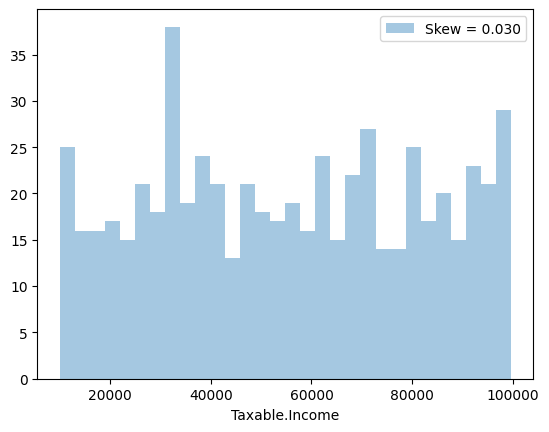

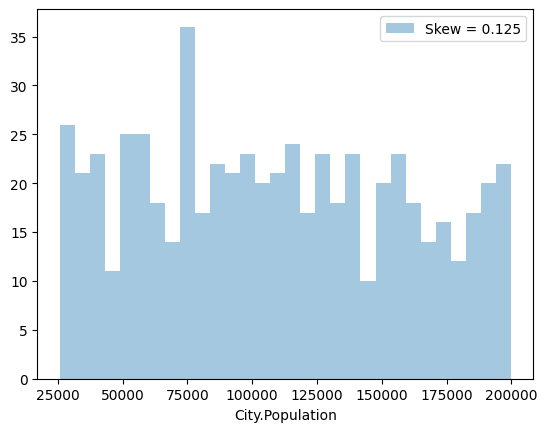

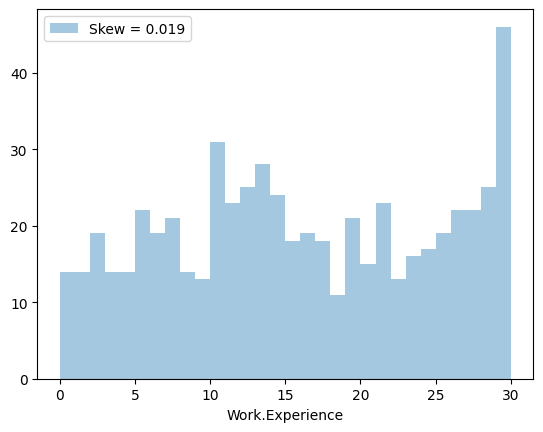

In [155]:
# Univariate plots
numerical_features=[feature for feature in data.columns if data[feature].dtypes != 'O']
for feat in numerical_features:
    skew = data[feat].skew()
    sns.distplot(data[feat], kde= False, label='Skew = %.3f' %(skew), bins=30)
    plt.legend(loc='best')
    plt.show()


In [156]:
# Detect observations with more than one outlier

def outlier_hunt(data):
    """
    Takes a dataframe df of features and returns a list of the indices
    corresponding to the observations containing more than 2 outliers.
    """
    outlier_indices = []

    # iterate over features(columns)
    for col in data.columns.tolist():
        # 1st quartile (25%)
        Q1 = np.percentile(data[col], 25)

        # 3rd quartile (75%)
        Q3 = np.percentile(data[col],75)

        # Interquartile rrange (IQR)
        IQR = Q3 - Q1

        # outlier step
        outlier_step = 1.5 * IQR

        # Determine a list of indices of outliers for feature col
        outlier_list_col = data[(data[col] < Q1 - outlier_step) | (data[col] > Q3 + outlier_step )].index

        # append the found outlier indices for col to the list of outlier indices
        outlier_indices.extend(outlier_list_col)

    # select observations containing more than 2 outliers
    outlier_indices = Counter(outlier_indices)
    multiple_outliers = list( k for k, v in outlier_indices.items() if v > 2 )

    return multiple_outliers

print('The dataset contains %d observations with more than 2 outliers' %(len(outlier_hunt(data[numerical_features]))))

The dataset contains 0 observations with more than 2 outliers


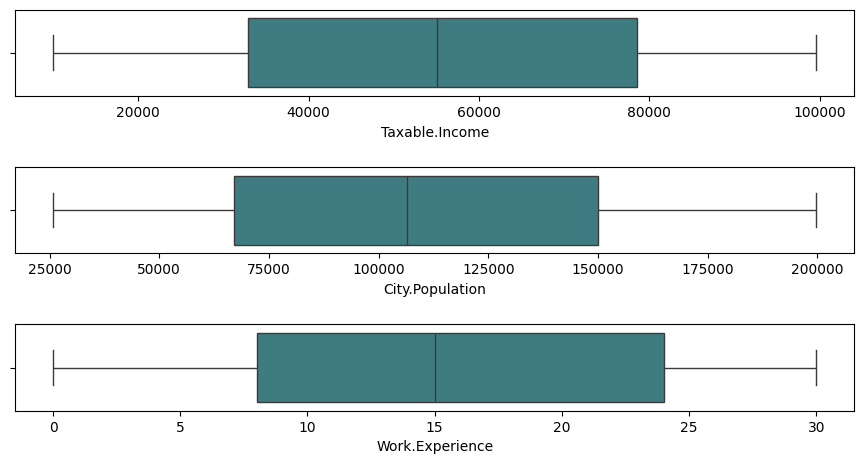

In [157]:
outlier = data.copy()
fig, axes = plt.subplots(3,1,figsize=(9,5),sharex=False,sharey=False)
sns.boxplot(x='Taxable.Income',data= outlier,palette='crest',ax=axes[0])
sns.boxplot(x='City.Population',data= outlier,palette='crest',ax=axes[1])
sns.boxplot(x='Work.Experience',data= outlier,palette='crest',ax=axes[2])
plt.tight_layout(pad=2.0)

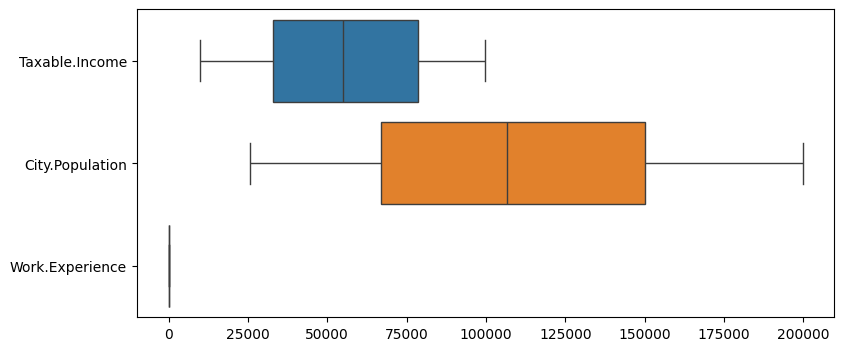

In [158]:
plt.figure(figsize=(9,4))
sns.boxplot(data= data[numerical_features], orient="h")
plt.show()

### Work Experience has a mean that is much inferior to the other constituents as we already saw in the previous section.

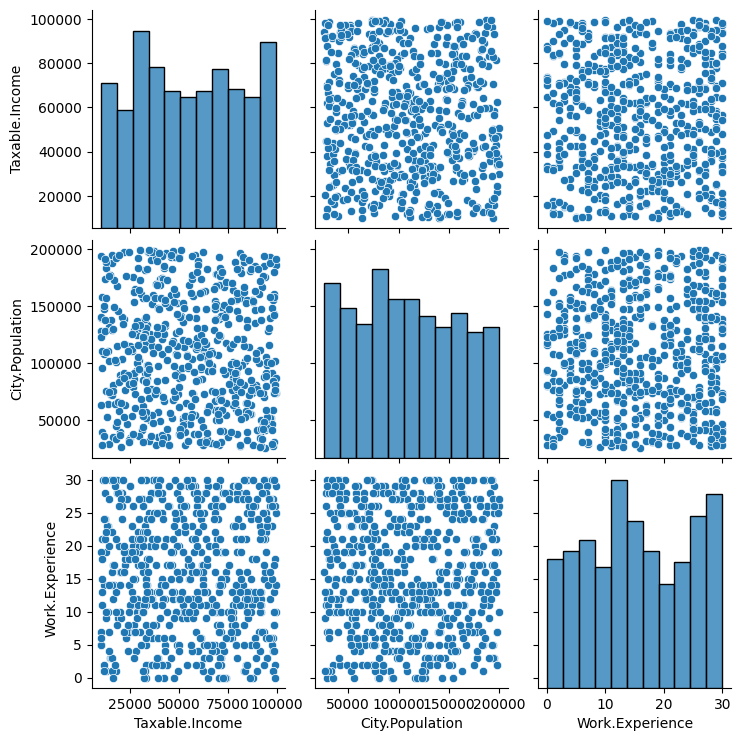

In [159]:
# Multivariate Analysis
sns.pairplot(data, palette='coolwarm')
plt.show()

# Correlation Analysis

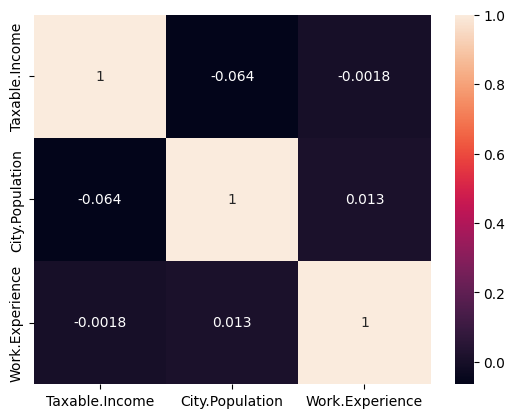

In [160]:
sns.heatmap(data.corr(), annot=True)
plt.show()

Index(['Undergrad', 'Marital.Status', 'Urban', 'taxable_category'], dtype='object')


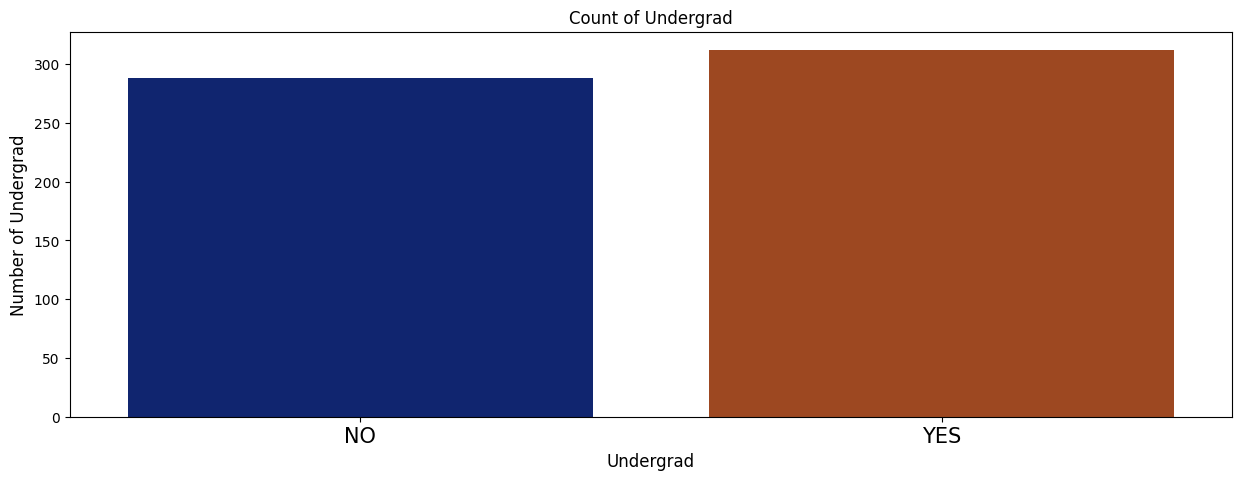

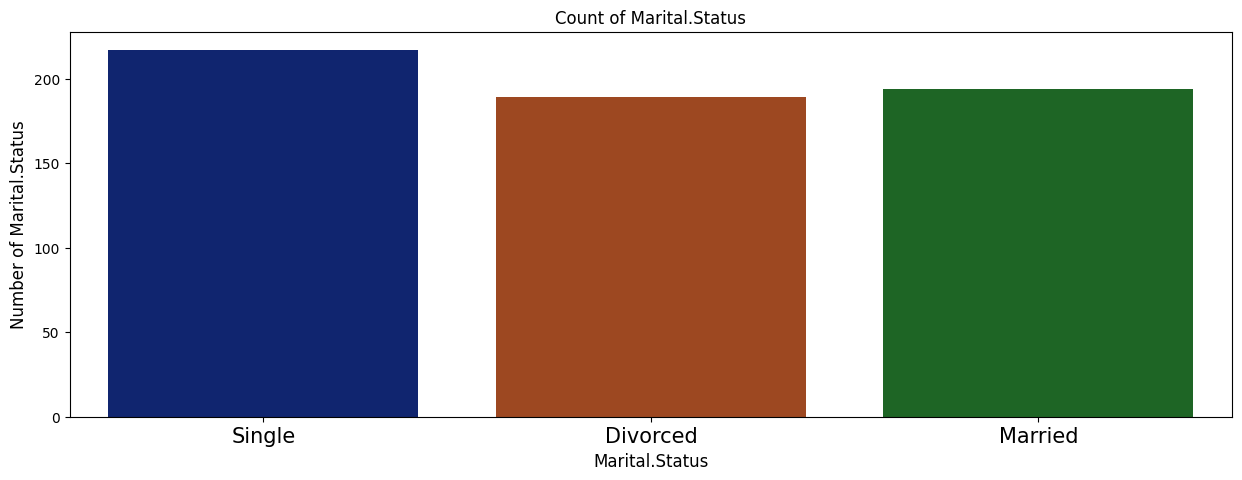

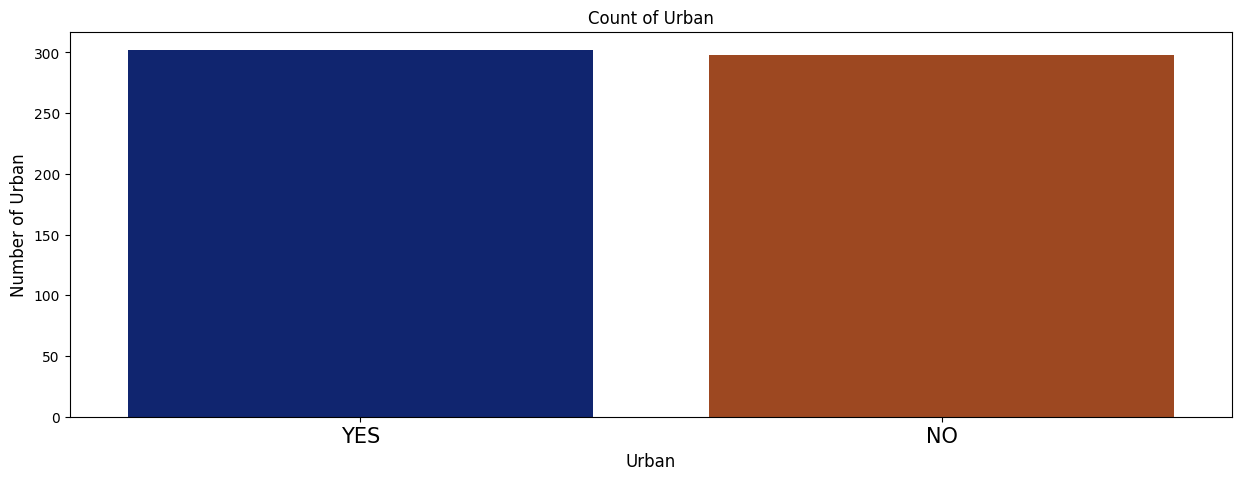

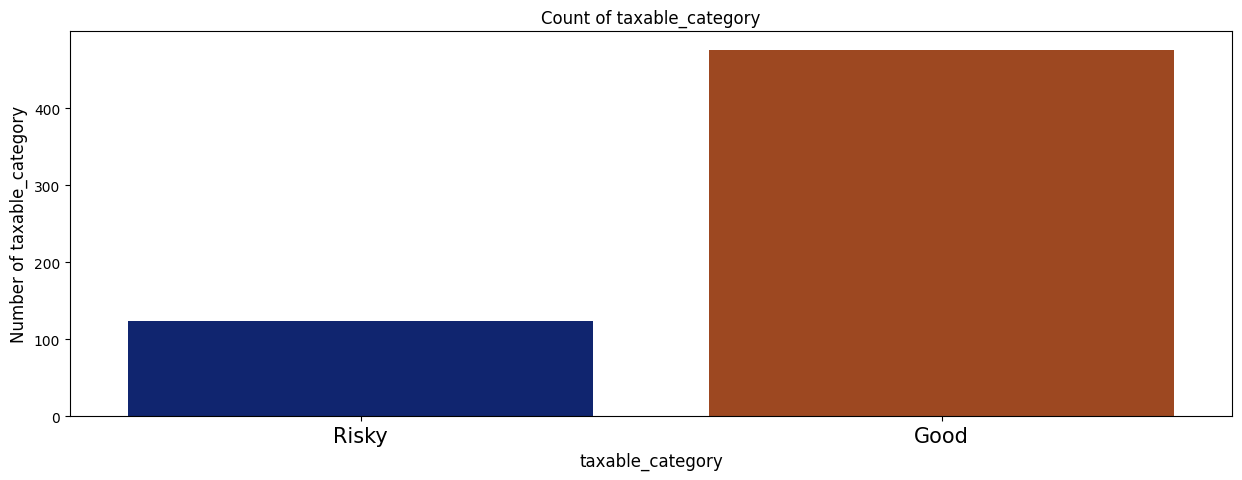

In [161]:
print(categorical_features)

for idx, column in enumerate(categorical_features):
    plt.figure(figsize=(15, 5))
    unique = data_new[column].value_counts(ascending=True);

    #plt.subplot(1, len(categorical_features), idx+1)
    plt.title("Count of "+ column)
    sns.countplot(data=data_new, x=column,palette = "dark")
    #plt.bar(unique.index, unique.values);
    plt.xticks(rotation = 0, size = 15)

    plt.xlabel(column, fontsize=12)
    plt.ylabel("Number of "+ column, fontsize=12)

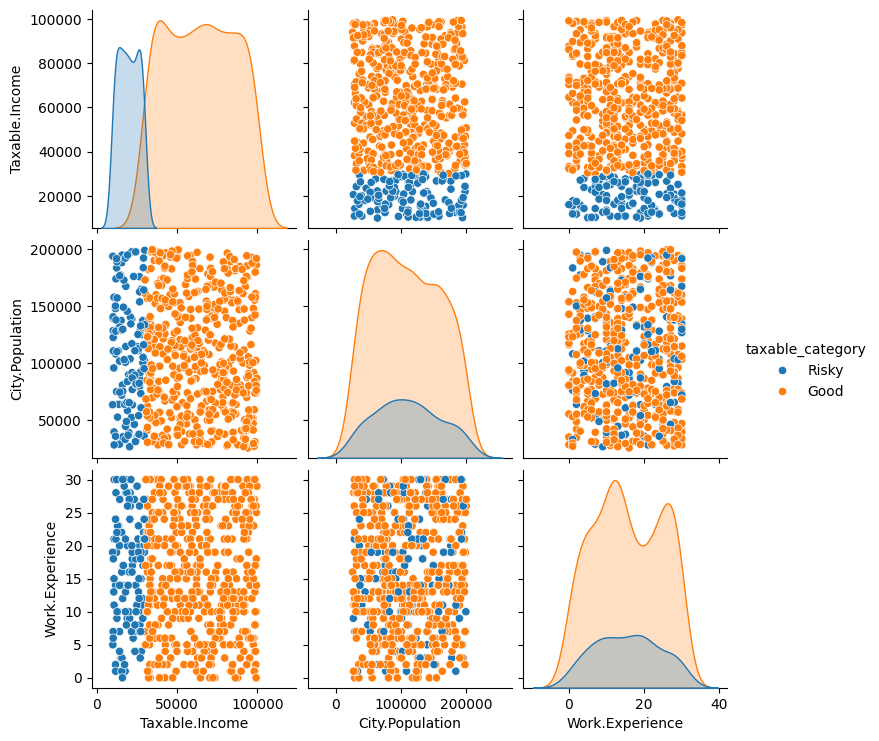

In [162]:
# let's plot pair plot to visualise the attributes all at once
import seaborn as sns
sns.pairplot(data=data_new, hue = 'taxable_category')

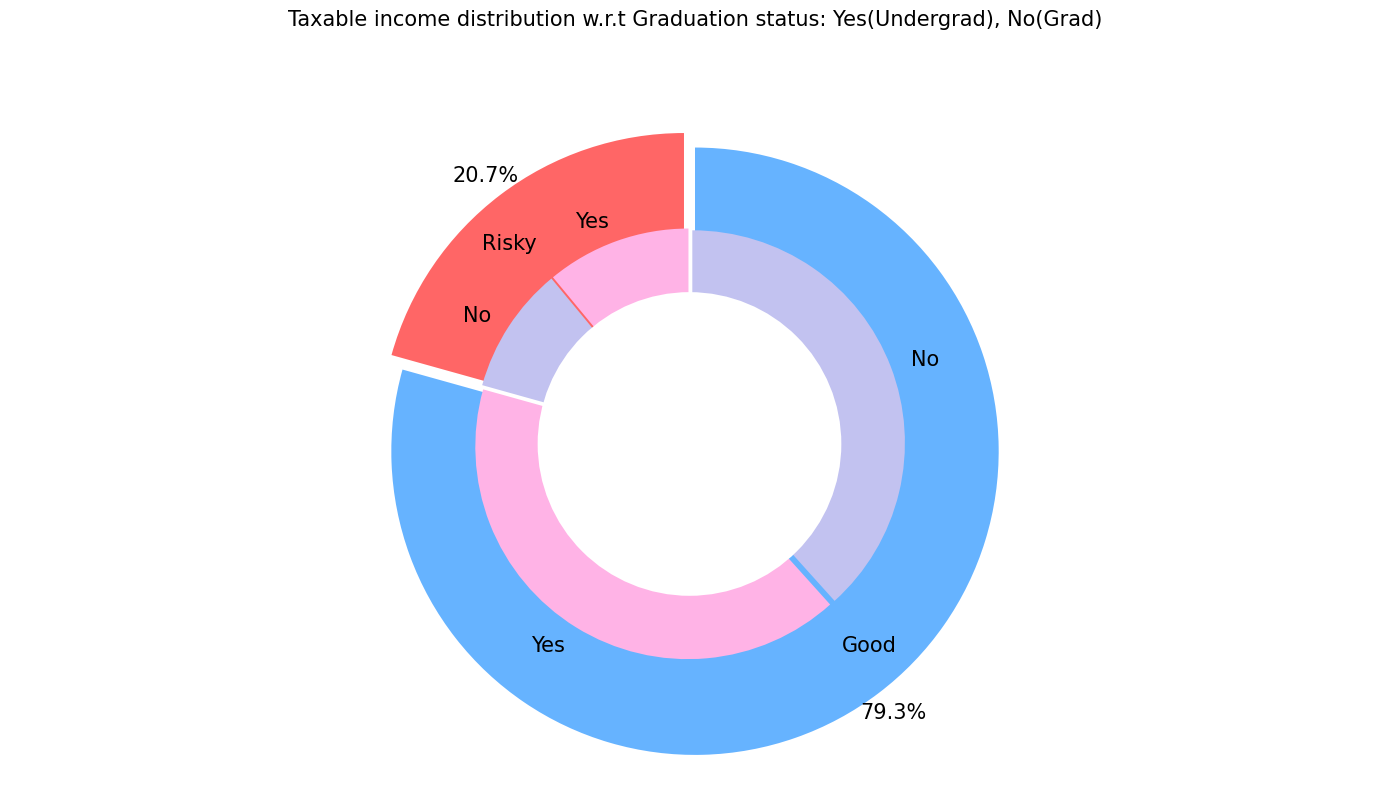

In [163]:
plt.figure(figsize=(14, 8))
labels =["Risky", "Good"]
values = [data_new["taxable_category"][data_new["taxable_category"] == 'Risky'].groupby(by = data_new.Undergrad).count().sum(),
         data_new["taxable_category"][data_new["taxable_category"] == 'Good'].groupby(by = data_new.Undergrad).count().sum()]
labels_gender = ["Yes","No","Yes","No"]
sizes_gender = [66,58 , 246,230]
colors = ['#ff6666', '#66b3ff']
colors_gender = ['#ffb3e6','#c2c2f0','#ffb3e6', '#c2c2f0']
explode = (0.3,0.3)
explode_gender = (0.1,0.1,0.1,0.1)
textprops = {"fontsize":15}
#Plot
plt.pie(values, labels=labels,autopct='%1.1f%%',pctdistance=1.08, labeldistance=0.8,colors=colors, startangle=90,frame=True, explode=explode,radius=10, textprops =textprops, counterclock = True, )
plt.pie(sizes_gender,labels=labels_gender,colors=colors_gender,startangle=90, explode=explode_gender,radius=7, textprops =textprops, counterclock = True, )
#Draw circle
centre_circle = plt.Circle((0,0),5,color='black', fc='white',linewidth=0)
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

plt.title('Taxable income distribution w.r.t Graduation status: Yes(Undergrad), No(Grad)', fontsize=15, y=1.1)

# show plot

plt.axis('equal')
plt.tight_layout()
plt.show()

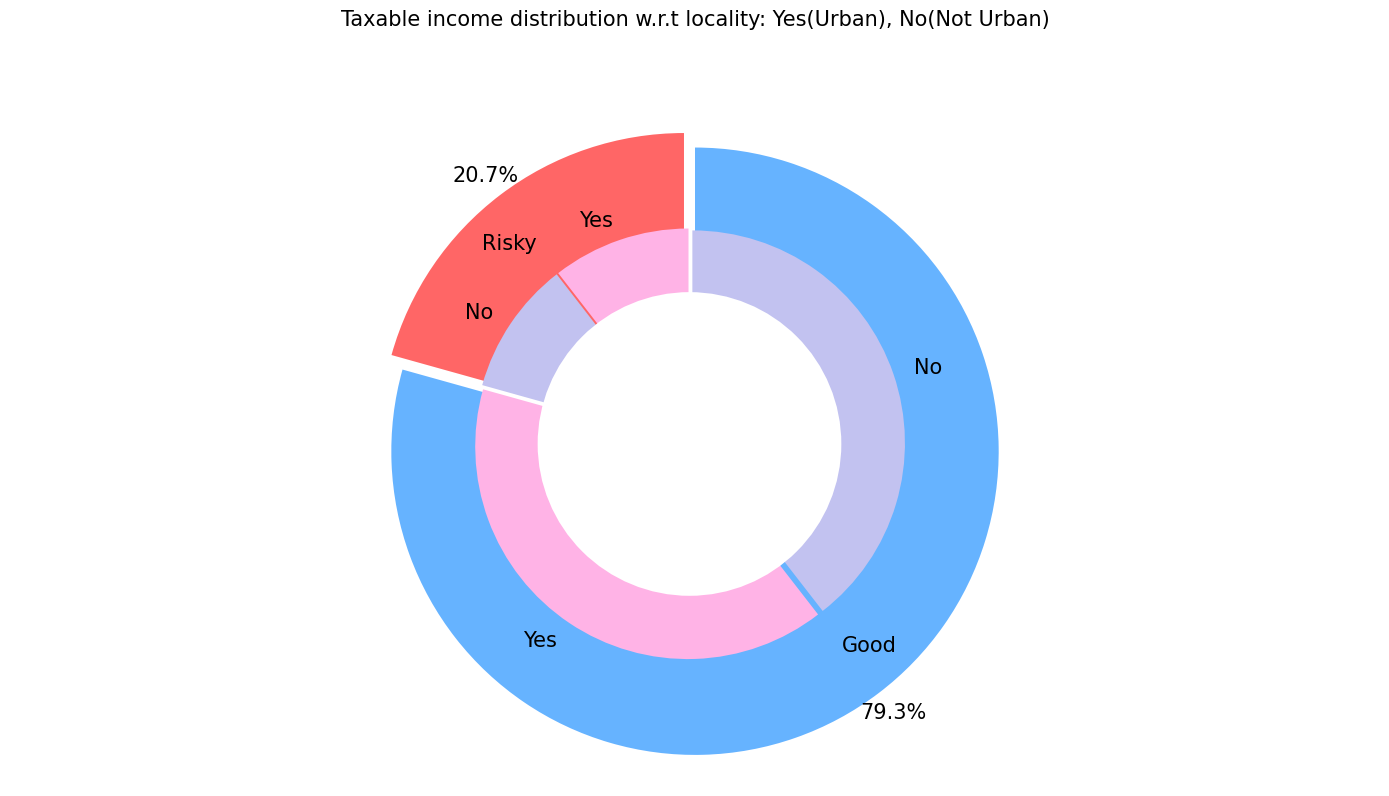

In [164]:
plt.figure(figsize=(14, 8))
labels =["Risky", "Good"]
values = [data_new["taxable_category"][data_new["taxable_category"] == 'Risky'].groupby(by = data_new.Urban).count().sum(),
         data_new["taxable_category"][data_new["taxable_category"] == 'Good'].groupby(by = data_new.Urban).count().sum()]
labels_gender = ["Yes","No","Yes","No"]
sizes_gender = [63,61 , 239,237]
colors = ['#ff6666', '#66b3ff']
colors_gender = ['#ffb3e6','#c2c2f0','#ffb3e6', '#c2c2f0']
explode = (0.3,0.3)
explode_gender = (0.1,0.1,0.1,0.1)
textprops = {"fontsize":15}
#Plot
plt.pie(values, labels=labels,autopct='%1.1f%%',pctdistance=1.08, labeldistance=0.8,colors=colors, startangle=90,frame=True, explode=explode,radius=10, textprops =textprops, counterclock = True, )
plt.pie(sizes_gender,labels=labels_gender,colors=colors_gender,startangle=90, explode=explode_gender,radius=7, textprops =textprops, counterclock = True, )
#Draw circle
centre_circle = plt.Circle((0,0),5,color='black', fc='white',linewidth=0)
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

plt.title('Taxable income distribution w.r.t locality: Yes(Urban), No(Not Urban)', fontsize=15, y=1.1)

# show plot

plt.axis('equal')
plt.tight_layout()
plt.show()

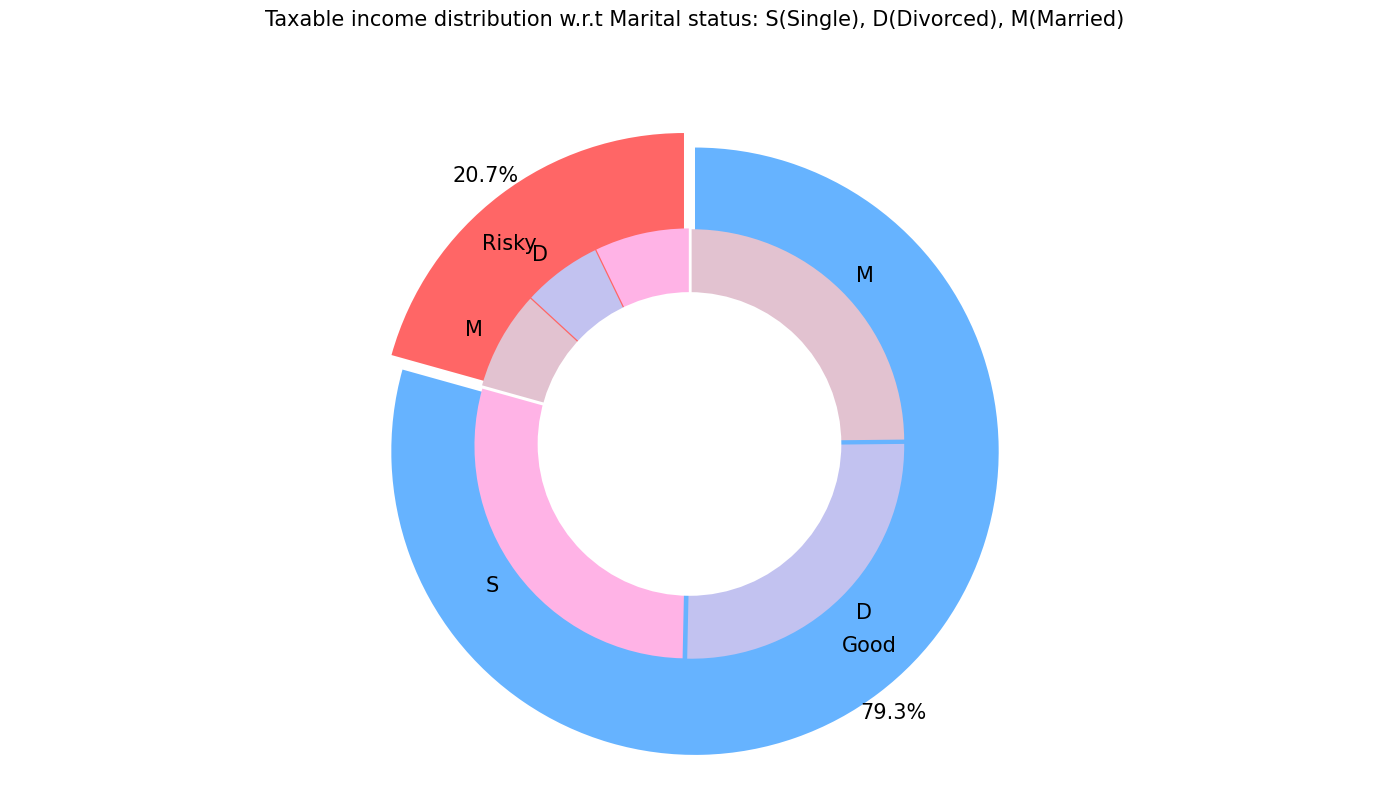

In [165]:
plt.figure(figsize=(14, 8))
labels =["Risky", "Good"]
values = [data_new["taxable_category"][data_new["taxable_category"] == 'Risky'].groupby(by = data_new["Marital.Status"]).count().sum(),
         data_new["taxable_category"][data_new["taxable_category"] == 'Good'].groupby(by = data_new["Marital.Status"]).count().sum()]
labels_gender = ["","D","M","S","D", "M"]
sizes_gender = [43,36,45,174,153,149]
colors = ['#ff6666', '#66b3ff']
colors_gender = ['#ffb3e6','#c2c2f0','#e2c2d0','#ffb3e6', '#c2c2f0', '#e2c2d0']
explode = (0.3,0.3)
explode_gender = (0.1,0.1,0.1,0.1,0.1,0.1)
textprops = {"fontsize":15}
#Plot
plt.pie(values, labels=labels,autopct='%1.1f%%',pctdistance=1.08, labeldistance=0.8,colors=colors, startangle=90,frame=True, explode=explode,radius=10, textprops =textprops, counterclock = True, )
plt.pie(sizes_gender,labels=labels_gender,colors=colors_gender,startangle=90, explode=explode_gender,radius=7, textprops =textprops, counterclock = True, )
#Draw circle
centre_circle = plt.Circle((0,0),5,color='black', fc='white',linewidth=0)
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

plt.title('Taxable income distribution w.r.t Marital status: S(Single), D(Divorced), M(Married)', fontsize=15, y=1.1)

# show plot

plt.axis('equal')
plt.tight_layout()
plt.show()

In [166]:
df = data_new.copy()
df.drop('Taxable.Income',axis=1, inplace =True)
df = pd.get_dummies(df.iloc[:,:-1])
df.head()

,City.Population,Work.Experience,Undergrad_NO,Undergrad_YES,Marital.Status_Divorced,Marital.Status_Married,Marital.Status_Single,Urban_NO,Urban_YES
0,50047,10,1,0,0,0,1,0,1
1,134075,18,0,1,1,0,0,0,1
2,160205,30,1,0,0,1,0,0,1
3,193264,15,0,1,0,0,1,0,1
4,27533,28,1,0,0,1,0,1,0


Text(0.5, 1.0, 'Correlation with Sales \n')

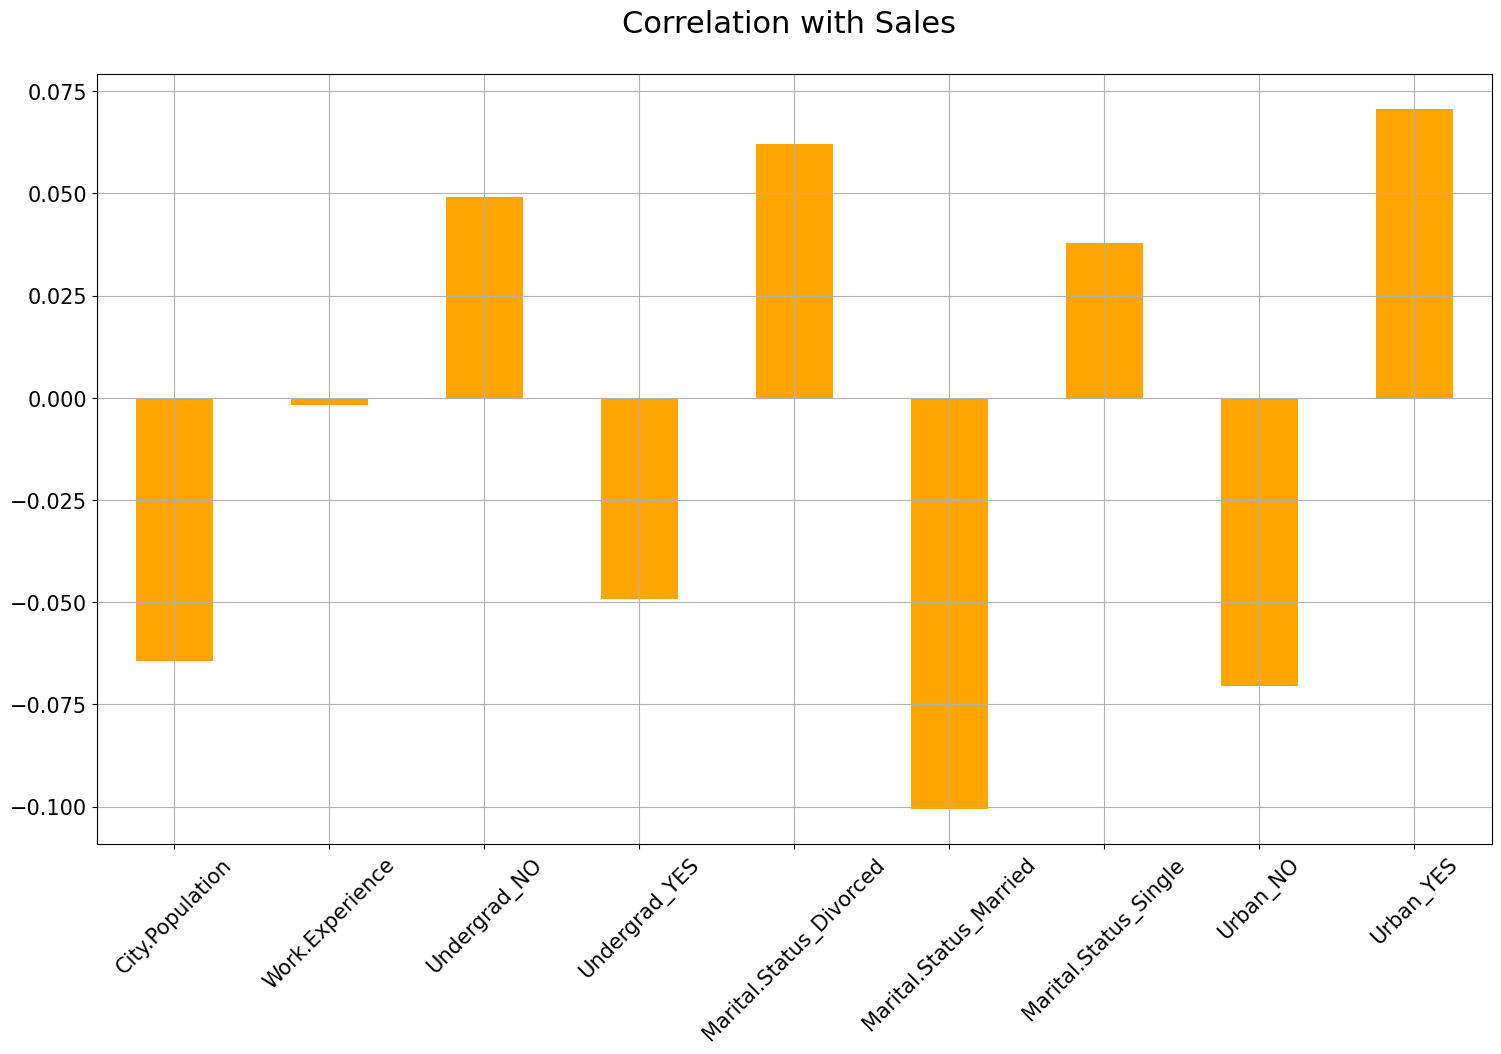

In [167]:
df_new = df.copy()

correlations = df_new.corrwith(data_new['Taxable.Income'])
correlations = correlations[correlations!=1]
positive_correlations = correlations[correlations >0].sort_values(ascending = False)
negative_correlations =correlations[correlations<0].sort_values(ascending = False)

correlations.plot.bar(
        figsize = (18, 10),
        fontsize = 15,
        color = 'orange',
        rot = 45, grid = True)
plt.title('Correlation with Sales \n',
horizontalalignment="center", fontstyle = "normal",
fontsize = "22", fontfamily = "sans-serif")

In [168]:
data_new.head()

,Undergrad,Marital.Status,Taxable.Income,City.Population,Work.Experience,Urban,taxable_category
0,NO,Single,68833,50047,10,YES,Good
1,YES,Divorced,33700,134075,18,YES,Good
2,NO,Married,36925,160205,30,YES,Good
3,YES,Single,50190,193264,15,YES,Good
4,NO,Married,81002,27533,28,NO,Good


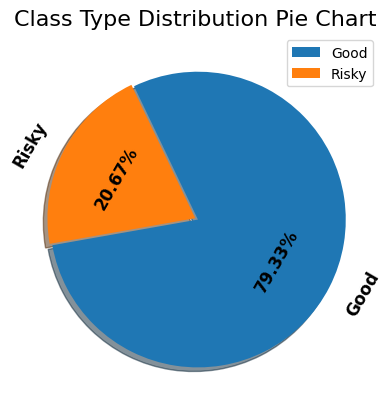

In [169]:
# Checking for Imbalanced or balanced dataset with regards to the Target
plt.pie(data_new['taxable_category'].value_counts(), labels= data_new['taxable_category'].unique(),
       explode = [0.02,0.0], autopct= '%.2f%%', shadow= True, startangle= 190,
       textprops = {'size':'large', 'fontweight':'bold', 'rotation': 60, 'color':'black'})
plt.legend(loc= 'upper right')
plt.title("Class Type Distribution Pie Chart", fontsize = 16)
plt.show()

### The class “Good” is called the majority class, and the much smaller in size “Risky” class is called the minority class.

In [170]:
countNotermdeposit = len(data_new[data_new['taxable_category'] == 'Good'])
counthavetermdeposit = len(data_new[data_new['taxable_category'] == 'Risky'])
print("Percentage of Customer doesn't have a term deposit: {:.2f}%".format((countNotermdeposit / (len(data_new['taxable_category']))*100)))
print("Percentage of Customer have a term deposit: {:.2f}%".format((counthavetermdeposit / (len(data_new['taxable_category']))*100)))

Percentage of Customer doesn't have a term deposit: 79.33%
Percentage of Customer have a term deposit: 20.67%


In [171]:
data_new['taxable_category'].value_counts()

Good     476
Risky    124
Name: taxable_category, dtype: int64

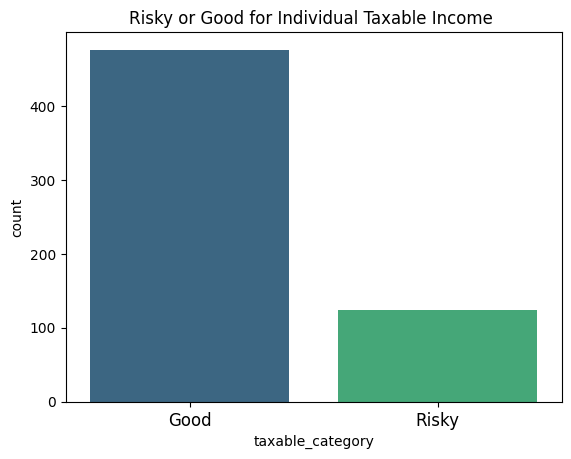

In [172]:
sns.countplot(x='taxable_category', data= data_new, palette = 'viridis',
              order=data_new['taxable_category'].value_counts().index)
plt.xticks(fontsize = 12)
plt.title('Risky or Good for Individual Taxable Income ')
plt.show()

# Data Pre-Processing


In [173]:
# Feature Selection Technique
data_new.columns

Index(['Undergrad', 'Marital.Status', 'Taxable.Income', 'City.Population',
       'Work.Experience', 'Urban', 'taxable_category'],
      dtype='object')

In [174]:
fraud = data_new.copy()
fraud.rename(columns={'Marital.Status':'Marital_Status', 'Taxable.Income':'Taxable_Income','City.Population':'City_Population','Work.Experience':'Work_Experience'}, inplace = True)
fraud.drop('Taxable_Income', axis=1, inplace = True)
categorical_features = fraud.describe(include=["object",'category']).columns
categorical_features

Index(['Undergrad', 'Marital_Status', 'Urban', 'taxable_category'], dtype='object')

# Lable Encoding

In [175]:
fraud.columns

Index(['Undergrad', 'Marital_Status', 'City_Population', 'Work_Experience',
       'Urban', 'taxable_category'],
      dtype='object')

In [176]:
le = LabelEncoder()
for col in categorical_features:
        le.fit(fraud[col])
        fraud[col] = le.transform(fraud[col])
fraud.head()

,Undergrad,Marital_Status,City_Population,Work_Experience,Urban,taxable_category
0,0,2,50047,10,1,0
1,1,0,134075,18,1,0
2,0,1,160205,30,1,0
3,1,2,193264,15,1,0
4,0,1,27533,28,0,0


# Feature Selection Technique


In [177]:
fraud_check = data_new.copy()
fraud_check.drop('Taxable.Income',axis=1, inplace =True)
fraud_check = pd.get_dummies(fraud_check.iloc[:,:-1])
fraud_check.head()

,City.Population,Work.Experience,Undergrad_NO,Undergrad_YES,Marital.Status_Divorced,Marital.Status_Married,Marital.Status_Single,Urban_NO,Urban_YES
0,50047,10,1,0,0,0,1,0,1
1,134075,18,0,1,1,0,0,0,1
2,160205,30,1,0,0,1,0,0,1
3,193264,15,0,1,0,0,1,0,1
4,27533,28,1,0,0,1,0,1,0


In [178]:
fraud_check['Taxable_Income'] = data_new['taxable_category']
fraud_check.head()

,City.Population,Work.Experience,Undergrad_NO,Undergrad_YES,Marital.Status_Divorced,Marital.Status_Married,Marital.Status_Single,Urban_NO,Urban_YES,Taxable_Income
0,50047,10,1,0,0,0,1,0,1,Good
1,134075,18,0,1,1,0,0,0,1,Good
2,160205,30,1,0,0,1,0,0,1,Good
3,193264,15,0,1,0,0,1,0,1,Good
4,27533,28,1,0,0,1,0,1,0,Good


In [179]:
le = LabelEncoder()
le.fit(fraud_check["Taxable_Income"])
fraud_check["Taxable_Income"]=le.transform(fraud_check["Taxable_Income"])
fraud_check.head()

,City.Population,Work.Experience,Undergrad_NO,Undergrad_YES,Marital.Status_Divorced,Marital.Status_Married,Marital.Status_Single,Urban_NO,Urban_YES,Taxable_Income
0,50047,10,1,0,0,0,1,0,1,0
1,134075,18,0,1,1,0,0,0,1,0
2,160205,30,1,0,0,1,0,0,1,0
3,193264,15,0,1,0,0,1,0,1,0
4,27533,28,1,0,0,1,0,1,0,0


In [180]:
# Split into input (x) and output (y) variables
x = fraud_check.iloc[:, :-1]
y =  fraud_check.Taxable_Income

In [181]:
# Feature extraction
test = SelectKBest(score_func=chi2, k=5)
fit = test.fit(x, y)

In [182]:
# Summarize scores
scores = fit.scores_
features = fit.transform(x)

In [183]:
score_fraud_check = pd.DataFrame(list(zip(x.columns, scores)), columns =['Feature','Score'])
score_fraud_check.sort_values(by="Score", ascending=False, inplace=True)
score_fraud_check

,Feature,Score
0,City.Population,2045.643886
5,Marital.Status_Married,0.756912
4,Marital.Status_Divorced,0.302172
6,Marital.Status_Single,0.095850
2,Undergrad_NO,0.048929
3,Undergrad_YES,0.045165
1,Work.Experience,0.011709
7,Urban_NO,0.007044
8,Urban_YES,0.006951


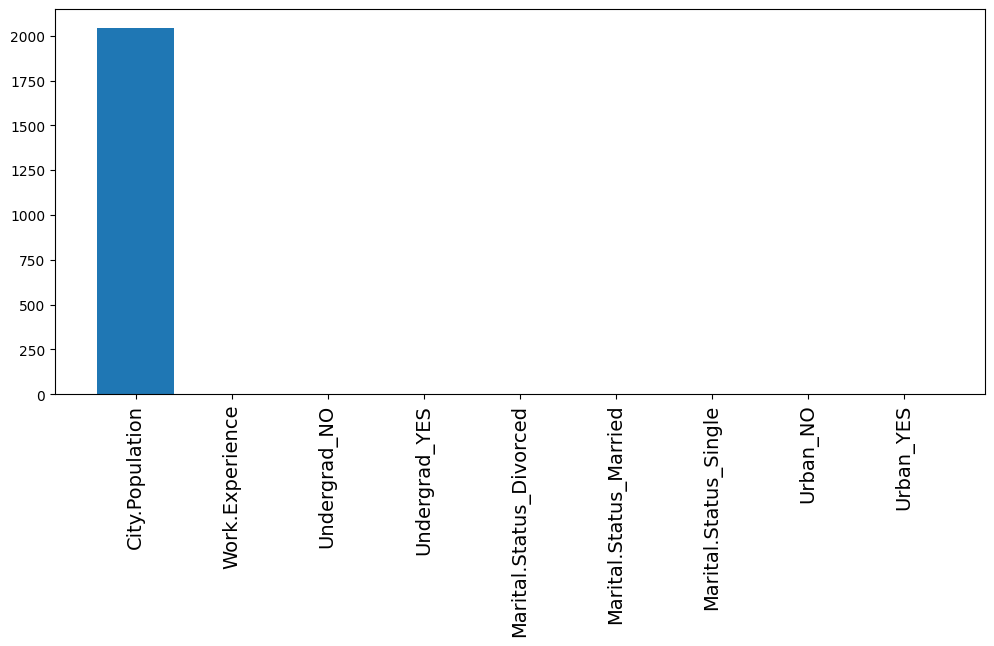

In [184]:
fig, axes = plt.subplots(figsize=(12,5))
plt.bar([i for i in range(len(scores))],scores)
axes.set_xticks([0,1,2,3,4,5,6,7,8])
axes.set_xticklabels(x.columns.values)
plt.xticks(rotation = 90, size = 14)
plt.show()

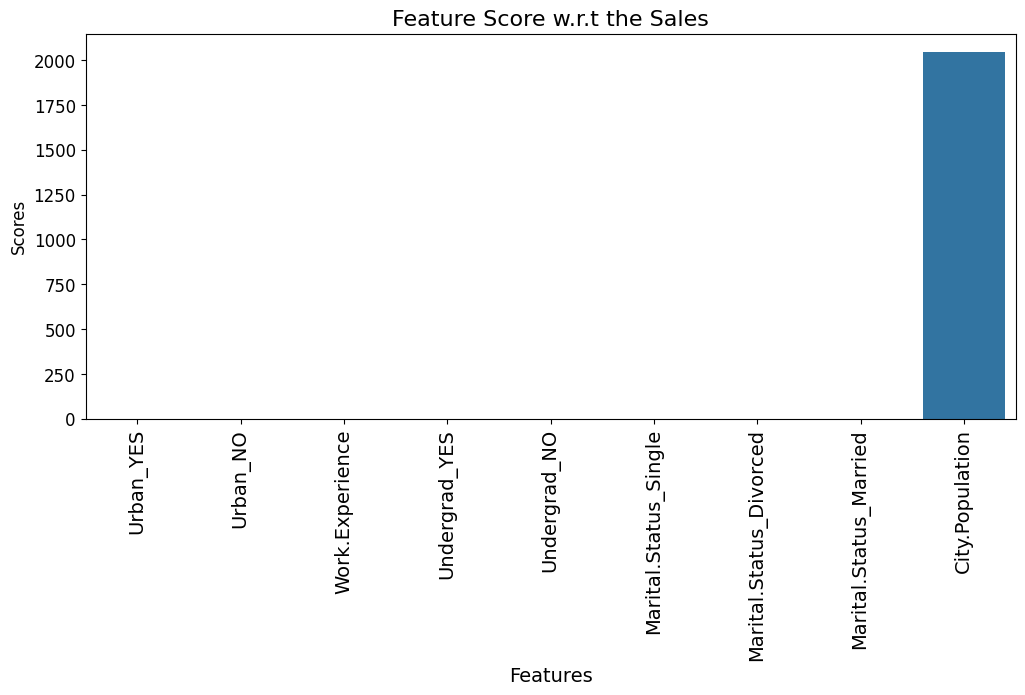

In [185]:
plt.figure(figsize=(12,5))
sns.barplot(x='Feature', y="Score", data=score_fraud_check, order=score_fraud_check.sort_values('Score').Feature)
plt.xlabel("Features", size=14)
plt.ylabel("Scores", size=12)
plt.yticks(rotation = 0, fontsize = 12)
plt.xticks(rotation = 90, fontsize = 14)
plt.title("Feature Score w.r.t the Sales", size=16)
plt.show()

# Random Forest Built-in Feature Importance

In [186]:
rf_classifier = RandomForestClassifier(random_state=42, n_jobs=-1, max_depth=5,n_estimators=100, oob_score=True)
rf_classifier.fit(x, y)

rf = RandomForestClassifier(random_state=42, n_jobs=-1)
params = {'max_depth': [2,3,5,10,20], 'min_samples_leaf': [5,10,20,50,100,200],'n_estimators': [10,25,30,50,100,200]}

grid_search = GridSearchCV(estimator= rf, param_grid=params, cv = 4, n_jobs=-1, verbose=1, scoring="accuracy")
grid_search.fit(x, y)
rf_best = grid_search.best_estimator_

print('Checking the oob score :', rf_classifier.oob_score_)
print('Best Score             :', grid_search.best_score_)
print('RF Best Model          :', rf_best)

Fitting 4 folds for each of 180 candidates, totalling 720 fits
Checking the oob score : 0.7933333333333333
Best Score             : 0.7933333333333333
RF Best Model          : RandomForestClassifier(max_depth=2, min_samples_leaf=5, n_estimators=10,
                       n_jobs=-1, random_state=42)


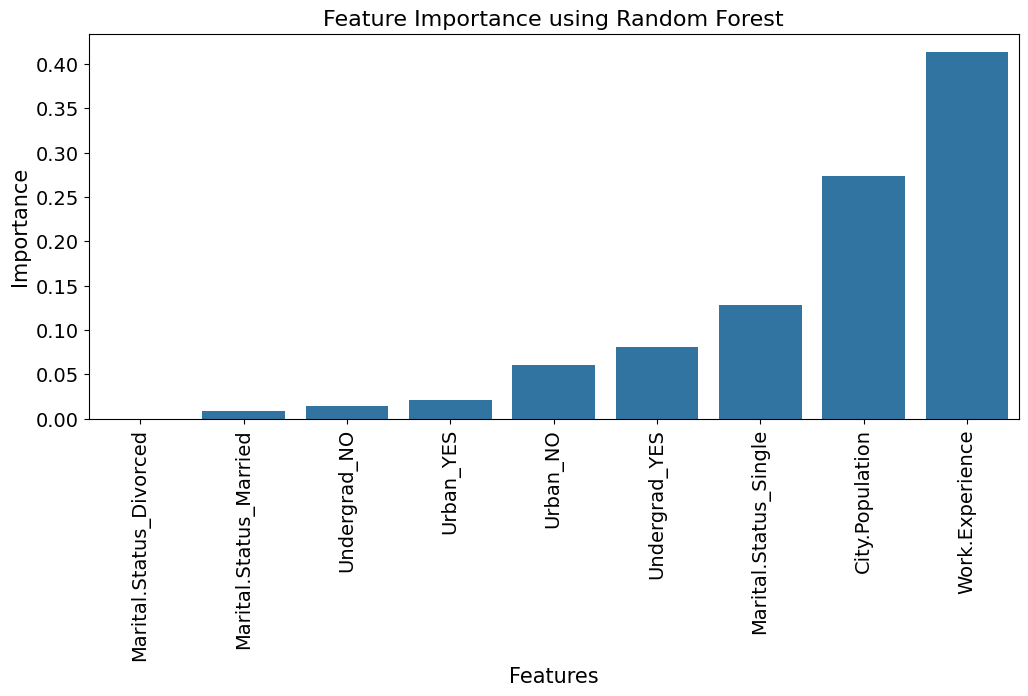

In [187]:
# Now let’s sort the data with the help of feature importance
rf_best.feature_importances_
imp_df = pd.DataFrame({"Feature": x.columns, "Importance": rf_best.feature_importances_})

plt.figure(figsize=(12,5))
sns.barplot(x= 'Feature', y= "Importance", data= imp_df, order= imp_df.sort_values('Importance').Feature)
plt.xlabel("Features", size=15)
plt.ylabel("Importance", size=15)
plt.yticks(rotation = 0, fontsize = 14)
plt.xticks(rotation = 90, fontsize = 14)
plt.title("Feature Importance using Random Forest", size=16)
plt.show()

In [188]:
# Test Train Split With Imbalanced Dataset
x = fraud.drop('taxable_category',axis=1)
y = fraud['taxable_category']


In [189]:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2,random_state=5,stratify=y)

In [190]:
print("Shape of x_train : ",x_train.shape)
print("Shape of x_test  : ",x_test.shape)
print("Shape of y_train : ",y_train.shape)
print("Shape of y_test  : ",y_test.shape)

Shape of x_train :  (480, 5)
Shape of x_test  :  (120, 5)
Shape of y_train :  (480,)
Shape of y_test  :  (120,)


# Stratified KFold

In [191]:
skf = StratifiedKFold(n_splits=15, shuffle=True, random_state=4)

# enumerate the splits and summarize the distributions
for train_ix, test_ix in skf.split(x, y):
# select rows
    train_x, test_x = x.iloc[train_ix], x.loc[test_ix]
    train_y, test_y = y.iloc[train_ix], y.iloc[test_ix]

# summarize train and test composition
counter_train = Counter(train_y)
counter_test = Counter(test_y)
print('Training Data :',counter_train)
print('Testing Data  :',counter_test)

Training Data : Counter({0: 445, 1: 115})
Testing Data  : Counter({0: 31, 1: 9})


### Stratify parameter makes a split so that the proportion of values in the sample produced will be the same as the proportion of values provided to parameter stratify

# Grid search using Stratified Kfold Splits on Imbalanced Dataset

In [192]:
def print_score(clf, X_train, y_train, X_test, y_test, train=True):
    if train:
        pred = clf.predict(X_train)
        clf_report = pd.DataFrame(classification_report(y_train, pred, output_dict=True))
        print("Train Result:\n================================================")
        print(f"Accuracy Score: {accuracy_score(y_train, pred) * 100:.2f}%")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(y_train, pred)}\n")

    elif train==False:
        pred = clf.predict(X_test)
        clf_report = pd.DataFrame(classification_report(y_test, pred, output_dict=True))
        print("Test Result:\n================================================")
        print(f"Accuracy Score: {accuracy_score(y_test, pred) * 100:.2f}%")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(y_test, pred)}\n")

In [193]:
rf_clf1 = RandomForestClassifier(n_estimators=100)
rf_clf1.fit(train_x, train_y)

print_score(rf_clf1, train_x, train_y, test_x, test_y, train=True)
print_score(rf_clf1, train_x, train_y, test_x, test_y, train=False)

Train Result:
Accuracy Score: 100.00%
_______________________________________________
CLASSIFICATION REPORT:
               0      1  accuracy  macro avg  weighted avg
precision    1.0    1.0       1.0        1.0           1.0
recall       1.0    1.0       1.0        1.0           1.0
f1-score     1.0    1.0       1.0        1.0           1.0
support    445.0  115.0       1.0      560.0         560.0
_______________________________________________
Confusion Matrix: 
 [[445   0]
 [  0 115]]

Test Result:
Accuracy Score: 75.00%
_______________________________________________
CLASSIFICATION REPORT:
                   0    1  accuracy  macro avg  weighted avg
precision   0.769231  0.0      0.75   0.384615      0.596154
recall      0.967742  0.0      0.75   0.483871      0.750000
f1-score    0.857143  0.0      0.75   0.428571      0.664286
support    31.000000  9.0      0.75  40.000000     40.000000
_______________________________________________
Confusion Matrix: 
 [[30  1]
 [ 9  0]]



# Grid search using Train Test Splits Stratifying Target feature on Imbalanced Dataset

In [194]:
rf_clf2 = RandomForestClassifier(n_estimators=100)
rf_clf2.fit(x_train, y_train)

print_score(rf_clf2, x_train, y_train, x_test, y_test, train=True)
print_score(rf_clf2, x_train, y_train, x_test, y_test, train=False)

Train Result:
Accuracy Score: 100.00%
_______________________________________________
CLASSIFICATION REPORT:
               0     1  accuracy  macro avg  weighted avg
precision    1.0   1.0       1.0        1.0           1.0
recall       1.0   1.0       1.0        1.0           1.0
f1-score     1.0   1.0       1.0        1.0           1.0
support    381.0  99.0       1.0      480.0         480.0
_______________________________________________
Confusion Matrix: 
 [[381   0]
 [  0  99]]

Test Result:
Accuracy Score: 75.00%
_______________________________________________
CLASSIFICATION REPORT:
                   0          1  accuracy   macro avg  weighted avg
precision   0.787611   0.142857      0.75    0.465234      0.653287
recall      0.936842   0.040000      0.75    0.488421      0.750000
f1-score    0.855769   0.062500      0.75    0.459135      0.690505
support    95.000000  25.000000      0.75  120.000000    120.000000
_______________________________________________
Confusion Matr

# Handling imbalance data using SMOTE based techniques


In [195]:
# SMOTE Oversampling technique
counter = Counter(y_train)
print('Before',counter)
smt = SMOTE()
x_train_sm, y_train_sm = smt.fit_resample(x_train, y_train)

counter = Counter(y_train_sm)
print('After',counter)

Before Counter({0: 381, 1: 99})
After Counter({1: 381, 0: 381})


In [196]:
# ADASYN: Adaptive Synthetic Sampling Approach
counter = Counter(y_train)
print('Before',counter)
ada = ADASYN(random_state=130)
x_train_ada, y_train_ada = ada.fit_resample(x_train, y_train)

counter = Counter(y_train_ada)
print('After',counter)

Before Counter({0: 381, 1: 99})
After Counter({1: 383, 0: 381})


In [197]:
# Hybridization: SMOTE + Tomek Links
counter = Counter(y_train)
print('Before',counter)
smtom = SMOTETomek(random_state=139)
x_train_smtom, y_train_smtom = smtom.fit_resample(x_train, y_train)

counter = Counter(y_train_smtom)
print('After',counter)

Before Counter({0: 381, 1: 99})
After Counter({1: 289, 0: 289})


In [198]:
# Hybridization: SMOTE + ENN
counter = Counter(y_train)
print('Before',counter)
smenn = SMOTEENN()
x_train_smenn, y_train_smenn = smenn.fit_resample(x_train, y_train)

counter = Counter(y_train_smenn)
print('After',counter)

Before Counter({0: 381, 1: 99})
After Counter({0: 114, 1: 105})


# Performance Analysis after Resampling

In [199]:
sample_data = {'ACTUAL':[x_train, y_train], 'SMOTE':[x_train_sm, y_train_sm], 'ADASYN':[x_train_ada, y_train_ada],
               'SMOTE_TOMEK':[x_train_smtom, y_train_smtom], 'SMOTE_ENN':[x_train_smenn, y_train_smenn]}

In [200]:
def test_eval(clf_model, x_test, y_test, algo= None, sampling=None):
    # Test set prediction
    y_prob = clf_model.predict_proba(x_test)
    y_pred = clf_model.predict(x_test)

    print('Confusion Matrix')
    print('='*60)
    print(confusion_matrix(y_test,y_pred),"\n")
    print('Classification Report')
    print('='*60)
    print(classification_report(y_test,y_pred),"\n")

    f1        = f1_score(y_test, y_pred, average='micro')
    recall    = recall_score(y_test, y_pred, average='micro')
    precision = precision_score(y_test, y_pred, average='micro')

    return algo,precision,recall,f1,sampling

In [201]:
model_params = {'random-forest' : {'model' : RandomForestClassifier(), 'params' : {"n_estimators": [5, 10, 15, 20, 25],
                'max_depth': [i for i in range(5,16,2)], 'min_samples_split': [2, 5, 10, 15, 20, 50, 100],
                'min_samples_leaf': [1, 2, 5], 'criterion': ['gini', 'entropy'], 'max_features': ['log2', 'sqrt', 'auto']}}}

In [202]:
cv = StratifiedKFold (n_splits=5, random_state=100, shuffle=True)
output = []
for model , model_hp in model_params.items():
    for resampl , data in sample_data.items():
        clf3 = RandomizedSearchCV (model_hp['model'], model_hp['params'], cv = cv, scoring='roc_auc', n_jobs=-1 )
        clf3.fit(data[0], data[1])
        clf_best1 = clf3.best_estimator_
        print('='*60)
        print(model+' with ' + resampl)
        print('-'*60)
        output.append(test_eval(clf_best1, x_test, y_test, model, resampl))

random-forest with ACTUAL
------------------------------------------------------------
Confusion Matrix
[[95  0]
 [25  0]] 

Classification Report
              precision    recall  f1-score   support

           0       0.79      1.00      0.88        95
           1       0.00      0.00      0.00        25

    accuracy                           0.79       120
   macro avg       0.40      0.50      0.44       120
weighted avg       0.63      0.79      0.70       120
 

random-forest with SMOTE
------------------------------------------------------------
Confusion Matrix
[[74 21]
 [17  8]] 

Classification Report
              precision    recall  f1-score   support

           0       0.81      0.78      0.80        95
           1       0.28      0.32      0.30        25

    accuracy                           0.68       120
   macro avg       0.54      0.55      0.55       120
weighted avg       0.70      0.68      0.69       120
 

random-forest with ADASYN
-----------------------

### As the results can be compared, ADASYN technique gave the best results we are going to use it further

In [203]:
counter = Counter(y_train)
print('Before',counter)
ada = ADASYN(random_state=130)
x_train_ada, y_train_ada = ada.fit_resample(x_train, y_train)

counter = Counter(y_train_ada)
print('After',counter)

Before Counter({0: 381, 1: 99})
After Counter({1: 383, 0: 381})


In [204]:
x_train,x_test,y_train,y_test = train_test_split(x_train_ada,y_train_ada,test_size=0.2,random_state=5, stratify=y_train_ada)

counter = Counter(y_train)
print('Train Counter    : ',counter)
counter = Counter(y_test)
print('Test Counter     : ',counter)
print("Shape of X_train : ",x_train.shape)
print("Shape of X_test  : ", x_test.shape)
print("Shape of y_train : ",y_train.shape)
print("Shape of y_test  : ",y_test.shape)

Train Counter    :  Counter({1: 306, 0: 305})
Test Counter     :  Counter({1: 77, 0: 76})
Shape of X_train :  (611, 5)
Shape of X_test  :  (153, 5)
Shape of y_train :  (611,)
Shape of y_test  :  (153,)


# Random Forest hyperparameter tuning

In [205]:
# Base model
score_array = []
for each in range(1,300):
    rf_loop = RandomForestClassifier(n_estimators = each, random_state = 7)
    rf_loop.fit(x_train,y_train)
    score_array.append(rf_loop.score(x_test,y_test))

In [206]:
loc = np.array(score_array).max()
score_array.index(loc)+1

5

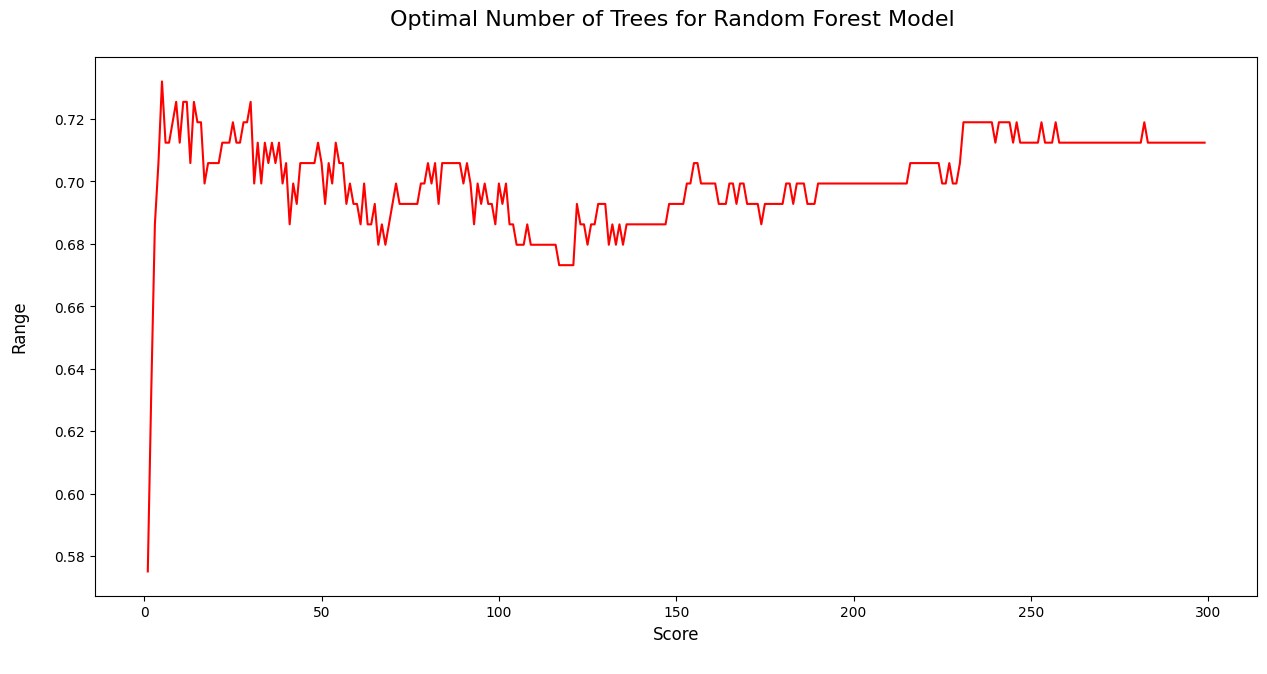

In [207]:
fig = plt.figure(figsize=(15, 7))
plt.plot(range(1,300),score_array, color = 'r')
plt.ylabel('Range\n',horizontalalignment="center",
fontstyle = "normal", fontsize = "large",
fontfamily = "sans-serif")
plt.xlabel('Score\n',horizontalalignment="center",
fontstyle = "normal", fontsize = "large",
fontfamily = "sans-serif")
plt.title('Optimal Number of Trees for Random Forest Model \n',horizontalalignment="center", fontsize = "16")
plt.xticks(rotation=0, horizontalalignment="center")
plt.yticks(rotation=0, horizontalalignment="right")
plt.show()

# Randomized Search Cross Validation

In [208]:
n_estimators = [int(x) for x in np.linspace(start=0, stop=200, num=200)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num=11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]

random_grid = {'n_estimators': n_estimators, 'max_features': max_features,
               'max_depth': max_depth, 'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf, 'bootstrap': bootstrap}

rf_clf = RandomForestClassifier(random_state=42)

rf_cv = RandomizedSearchCV(estimator=rf_clf, scoring='f1',param_distributions=random_grid, n_iter=100, cv=3,
                               verbose=2, random_state=42, n_jobs=-1)

rf_cv.fit(x_train, y_train)
rf_best_params = rf_cv.best_params_
print(f"Best paramters: {rf_best_params})")

rf_clf = RandomForestClassifier(**rf_best_params)
rf_clf.fit(x_train, y_train)

print_score(rf_clf, x_train, y_train, x_test, y_test, train=True)
print_score(rf_clf, x_train, y_train, x_test, y_test, train=False)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
Best paramters: {'n_estimators': 169, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'auto', 'max_depth': 10, 'bootstrap': True})
Train Result:
Accuracy Score: 90.67%
_______________________________________________
CLASSIFICATION REPORT:
                    0           1  accuracy   macro avg  weighted avg
precision    0.930556    0.885449   0.90671    0.908002      0.907965
recall       0.878689    0.934641   0.90671    0.906665      0.906710
f1-score     0.903879    0.909380   0.90671    0.906629      0.906634
support    305.000000  306.000000   0.90671  611.000000    611.000000
_______________________________________________
Confusion Matrix: 
 [[268  37]
 [ 20 286]]

Test Result:
Accuracy Score: 65.36%
_______________________________________________
CLASSIFICATION REPORT:
                   0          1  accuracy   macro avg  weighted avg
precision   0.671642   0.639535  0.653595    0.655588      0.65548

### Random search allowed us to narrow down the range for each hyperparameter. Now that we know where to concentrate our search, we can explicitly specify every combination of settings to try. We do this with GridSearchCV, a method that, instead of sampling randomly from a distribution, evaluates all combinations we define

# Grid Search Cross Validation

In [140]:
pipe_rfc = Pipeline([('scl', StandardScaler()), ('rfc', RandomForestClassifier(random_state=0, n_jobs=-1) )])
param_grid_rfc =  [{'rfc__n_estimators': [100, 200,300,400], 'rfc__max_features':[0.05 , 0.1],
                    'rfc__max_depth': [None, 5], 'rfc__min_samples_split': [0.005, 0.01]}]

kfold = StratifiedKFold(n_splits=10, shuffle=True,random_state= 0)
grid_rfc = GridSearchCV(pipe_rfc, param_grid= param_grid_rfc, cv=kfold, scoring='f1', verbose= 1, n_jobs=-1)

start = time()
grid_rfc = grid_rfc.fit(x_train, y_train)
end = time()

print("RFC grid search took %.3f seconds" %(end-start))
print('-------Best score----------')
print(grid_rfc.best_score_ * 100.0)
print('-------Best params----------')
print(grid_rfc.best_params_)

Fitting 10 folds for each of 32 candidates, totalling 320 fits
RFC grid search took 136.204 seconds
-------Best score----------
70.8490289873946
-------Best params----------
{'rfc__max_depth': None, 'rfc__max_features': 0.05, 'rfc__min_samples_split': 0.005, 'rfc__n_estimators': 400}


In [209]:
rf_best = rf_cv.best_estimator_
rf_best

RandomForestClassifier(max_depth=10, max_features='auto', min_samples_leaf=2,
                       n_estimators=169, random_state=42)

In [210]:
data_new['taxable_category'].unique()

['Good', 'Risky']
Categories (2, object): ['Risky' < 'Good']

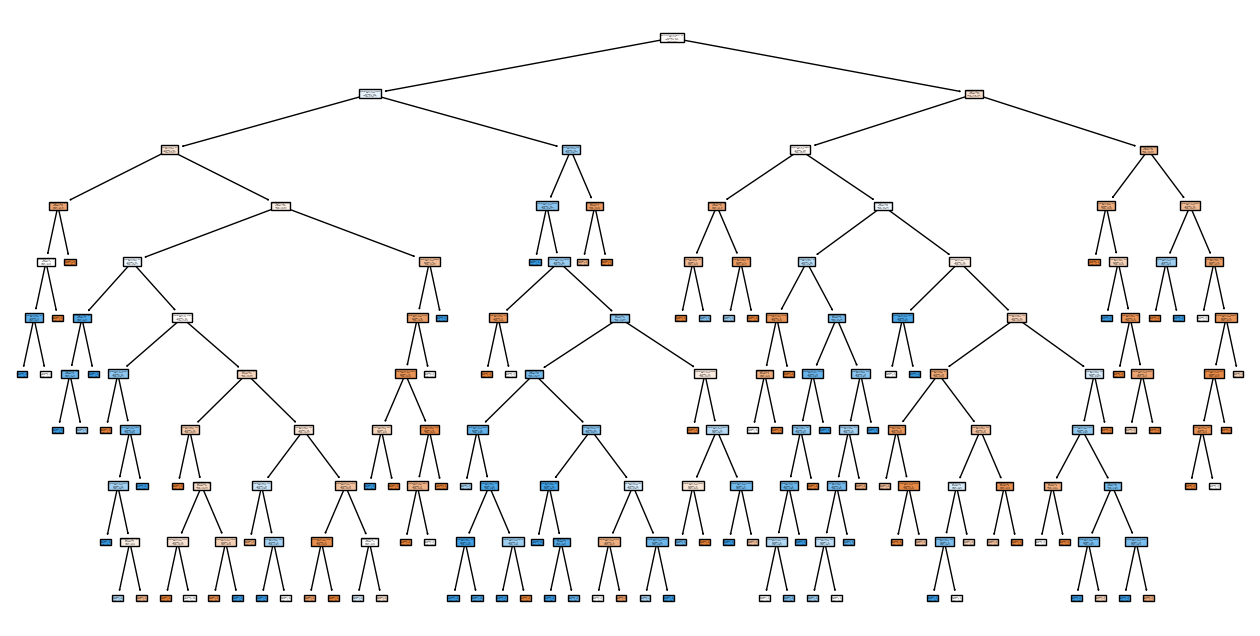

In [214]:
plt.figure(figsize=(16,8))
plot_tree(rf_best.estimators_[59], feature_names = fraud_check.columns,class_names=data_new['taxable_category'].unique(),filled=True)
plt.show()